# Useful Links

Guide to tf.graphs, tf.data_types, tf.tensorboard and tf.saver:

https://www.easy-tensorflow.com/tf-tutorials/basics/graph-and-session

Guide to adversarial examples:

https://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/

Explanation of reuse property:

https://medium.com/@hideyuki/what-does-variable-reuse-mean-in-tensorflow-40e86535026b

Guide to Pillow library:

https://pillow.readthedocs.io/en/latest/

Note: do not run "init_global_variables()" if restored inception weights before. That will override restoration and init new random weights. 

### Setup envirnonment 

In [1]:
%load_ext autoreload
%autoreload 2

### Import necessaary libraries

In [7]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

import tempfile
from urllib.request import urlretrieve
import tarfile
import os

import json
import matplotlib.pyplot as plt

import PIL
import numpy as np

import imp

### Import custom library

In [3]:
import patch_utils

# Useful functions

### Inception architecture 
(not for direct use)

In [2]:
# unfortunately, with simple session it is prohibited to use such functions;
# this still can be used for references or interactive sessions

# while initiaizing the model in tensorflow it is necessary to specify
# the input. The reason is how graphs work in tf. Input images should 
# be scaled to the range of [-1, 1] and have format (num_images, 299, 299, 3)
def inception(input_images):
    # download default values from the lib in the form of dictionary
    # keys include: activation_funcntion    (ReLU)
    #               decay                   (0.9997)
    #               normilizer              (batch_norm)
    #               etc.
    # keys you want to change you can type inside (*)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    
    # the following is a context manager. That is, within the space specified
    # with tf.contrib.framework.arg_scope(dict) values stored in  the dict are
    # automatically passed to all functions. That is, when we declare inception_v3()
    # instead of specifying each argument manually in a way inc_v3(decay = [dict['decay']]),
    # we have them automatically set.
    with tf.contrib.framework.arg_scope(arg_scope):
        
        # this function creates architecture (not weights) of inception_v3. It returns: 
        # tf_logits  - a vecotr of raw (not scaled to [0, 1]) scores for all of the classes
        #     of the net (i.e. its output tensor) you can apply softmax here to get probabilities
        #     or just get amax to find predicted class                                                 
        # end_points - a dictionary containing output tensors of important layers of the model
        tf_logits, end_points = tf.contrib.slim.nets.inception.inception_v3(input_images,
                                                                            num_classes=1001,   # default 
                                                                            is_training=False)
        
        # logits is a tensor of shape (?, 1001). We are interested only in teh second 
        # deimension of the tensor (because first is background class)
        tf_logits = tf_logits[:,1:]
        
        # get probabilities
        probs = tf.nn.softmax(tf_logits) 
    
        return probs

### Preprocess the image

In [73]:
# Input images should be scaled to the range of [-1, 1] and have format (num_images, 299, 299, 3)
# this function takes as an input *.jpg image (because *.png-s actually have 4-dims),
# crops it to the size 300x300, and convert to tensor. For convenience, it returns both scaled tensor
# and preprocessed image.
def preprocessing(raw_pillow_image):

    # scale the image in a way that maps its smaller dimension to the length of 300
    wide = raw_pillow_image.width > raw_pillow_image.height
    if wide:
        new_width = int(raw_pillow_image.width * 300 / raw_pillow_image.height)
        new_height = 300
    else:
        new_width = 300
        new_height = int(raw_pillow_image.height * 300 / raw_pillow_image.width)

    # catually scale image 
    raw_pillow_image = raw_pillow_image.resize((new_width, new_height))
    
    # crop exceeding dimension
    raw_pillow_image = raw_pillow_image.crop((0, 0, 300, 300))
    
    # scale to [0, 1]
    pillow_image = (np.asarray(raw_pillow_image) / 255.0).astype(np.float32)
    
    np_image = ((pillow_image - 0.5) * 2).reshape(1, 300, 300, 3)
    
    # add dimension in the start (becaus3e we have only one image) and convert to tensor 
    tf_image = tf.multiply(tf.subtract(tf.expand_dims(pillow_image, 0), 0.5), 2.0)
    
    return pillow_image, tf_image, np_image

### Plot the image

In [83]:
def show_image(img):
    imgplot = plt.imshow(img)
    plt.show()

### Plot the adversarial image

In [80]:
def plot_adversarial_image(my_adv_array):
    my_adv_array = ((my_adv_array / 2) + 0.5).reshape(300, 300, 3)
    show_image(my_adv_array)

### Plot 10 best probabilities

In [54]:
def show_probs(img, p, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    ax1.imshow(img)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

# Workspace

### Load labels

In [100]:
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

### Choose an image

In [64]:
img1_path = './ImageNet/467863966_a01cbd9d90.jpg'
img2_path = './ImageNet/857502810_4313e2fbd4.jpg'
img3_path = './ImageNet/81-yKbVND-L.png'
img4_path = ''
img5_path = './ImageNet/EJxGm89VUAERo8e.jpg'
img6_path = './ImageNet/flowers.jpg'

my_raw_pillow_image = PIL.Image.open(img6_path) 

### Classification cell

In [131]:
# Allows not to reboot kernel on each initialization
tf.reset_default_graph()   



# declare variable and pass initializer function to it
my_tf_image = tf.get_variable(name="my_img", 
                              initializer=preprocessing(my_raw_pillow_image)[1])



# download default values from the lib in the form of dictionary
# keys include: activation_funcntion    (ReLU)
#               decay                   (0.9997)
#               normilizer              (batch_norm)
#               etc.
# keys you want to change you can type inside (*)
arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)

# the following is a context manager. That is, within the space specified
# with tf.contrib.framework.arg_scope(dict) values stored in  the dict are
# automatically passed to all functions. That is, when we declare inception_v3()
# instead of specifying each argument manually in a way inc_v3(decay = [dict['decay']]),
# we have them automatically set.
with tf.contrib.framework.arg_scope(arg_scope):

    # this function creates architecture (not weights) of inception_v3. It returns: 
    # tf_logits  - a vecotr of raw (not scaled to [0, 1]) scores for all of the classes
    #     of the net (i.e. its output tensor) you can apply softmax here to get probabilities
    #     or just get amax to find predicted class                                                 
    # end_points - a dictionary containing output tensors of important layers of the model
    tf_logits, end_points = tf.contrib.slim.nets.inception.inception_v3(my_tf_image,
                                                                        num_classes=1001,   # default (somehow),
                                                                        is_training=False,  # but there are only 
                                                                        reuse = False)      # 1000 classes
                                                                        
    # logits is a tensor of shape (?, 1001). We are interested only in teh second 
    # deimension of the tensor (because first is background class)
    tf_logits = tf_logits[:,1:]

    # get probabilities
    probs = tf.nn.softmax(tf_logits) 



# declare variables to restore with saver; remember, that we want to restore
# only inception v3 variables and not our image; also note, that 
# tf.global_variables() returns all global variables declared after reset.
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]

# declate saver instance to restore vars when called
saver = tf.train.Saver(restore_vars)

# add an operation to initialize input
init_my_tf_image = tf.variables_initializer([my_tf_image])

INFO:tensorflow:Scale of 0 disables regularizer.


### Naive adversarial image (without clipping)

In [139]:
# somewhy utils do not automatically reload; so we have to do it manually
imp.reload(patch_utils)

# Allows not to reboot kernel on each initialization
tf.reset_default_graph()   



# declare variable and pass initializer function to it
my_tf_image = tf.get_variable(name="my_img", 
                              initializer=preprocessing(my_raw_pillow_image)[1])



# declare inception
arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
with tf.contrib.framework.arg_scope(arg_scope):
    tf_logits, end_points = tf.contrib.slim.nets.inception.inception_v3(my_tf_image,
                                                                        num_classes=1001,   
                                                                        is_training=False,  
                                                                        reuse = False)            
    tf_logits = tf_logits[:,1:]
    probs = tf.nn.softmax(tf_logits) 

    
    
# declare learning rate (operation & value)
learning_rate = tf.placeholder(tf.float32, ())    
    
# define place for target class (operation & value)
y_hat = tf.placeholder(tf.int32, ())    
# define array of labels, where y_hat element equals to 1, and all 
# other elements equal to 0 (operation & value)
labels = tf.one_hot(y_hat, 1000)

# compute loss (operation & value)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=tf_logits, labels=[labels])

# update x_hat
optim_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, var_list=[my_tf_image])



# declare variables to restore with saver
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]

# declate saver instance to restore vars when called
saver = tf.train.Saver(restore_vars)

# add an operation to initialize input
init_my_tf_image = tf.variables_initializer([my_tf_image])

INFO:tensorflow:Scale of 0 disables regularizer.


### Naive adversarial patch

In [99]:
# somewhy utils do not automatically reload; so we have to do it manually
imp.reload(patch_utils)

# Allows not to reboot kernel on each initialization
tf.reset_default_graph() 


# ============================================================================= #
# ============================= declare variables ============================= #
# ============================================================================= #



# declare variable for adversarial patch
naive_patch = tf.get_variable(name="patch", initializer=tf.zeros(shape = (50, 50, 3)))

# declare a placeholder for the image
train_image = tf.placeholder(name="train_image", shape=(1, 300, 300, 3), dtype=tf.float32)

# declare a placeholder for the length of train set image
train_set_length = tf.placeholder(name="train_set_length", shape=(), dtype=tf.int32)

# declare shifts
x_shifts = tf.placeholder(name="x_shifts", shape=(), dtype=tf.int32)
y_shifts = tf.placeholder(name="y_shifts", shape=(), dtype=tf.int32)

# declare learning rate
learning_rate = tf.placeholder(tf.float32, ())

# declare target class
y_hat = tf.placeholder(tf.int32, ())    

# declare initializer for variables
patch_initializer = tf.variables_initializer([naive_patch])



# ============================================================================= #
# ========================== preprocessing operations ========================= #
# ============================================================================= #

# multiply patch
patch_array = patch_utils.multiply(naive_patch, train_set_length)

# shift patch
shifted_patch_array = patch_utils.shift(patch_array, x_shifts, y_shifts)

# apply patch
adv_images = patch_utils.applicator(shifted_patch_array, train_image)

# ============================================================================= #
# =============================== gradient step =============================== #
# ============================================================================= #

# get target vector
labels = tf.one_hot(y_hat, 1000)

# declare inception
arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
with tf.contrib.framework.arg_scope(arg_scope):
    tf_logits, end_points = tf.contrib.slim.nets.inception.inception_v3(adv_images,
                                                                        num_classes=1001,   
                                                                        is_training=False,  
                                                                        reuse = False)            
    tf_logits = tf_logits[:,1:]
    probs = tf.nn.softmax(tf_logits) 


# compute loss (operation & value)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=tf_logits, labels=[labels])    

# update patch
optim_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, var_list=[naive_patch])

# ============================================================================= #
# ============================= process the result ============================ #
# ============================================================================= #



# get the result
result = adv_images

# debug function
printer = tf.print(result)



# ============================================================================= #
# =============================== declare saver =============================== #
# ============================================================================= #

# declare variables to restore with saver
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]

# declate saver instance to restore vars when called
saver = tf.train.Saver(restore_vars)

INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Save current graph

In [ ]:
# use this cell if you need to save graph to corresponding folder 
writer = tf.summary.FileWriter('./graphs', tf.get_default_graph())

# Run learning 

### Classification run

In [135]:
with tf.Session() as sess:
    # load weights of the model
    saver.restore(sess, './inception_v3_2016_08_28/inception_v3.ckpt')
    
    # run the variable initializer operation
    sess.run(init_my_tf_image)    
    
    # now let's evaluate their value
    my_probs = sess.run(probs)[0]
    

INFO:tensorflow:Restoring parameters from ./inception_v3_2016_08_28/inception_v3.ckpt


### Naive adversarial image run (without clipping)

In [140]:
# set variables
demo_lr = 5
demo_steps = 30
demo_target = 500 


with tf.Session() as sess:
    # load weights of the model
    saver.restore(sess, './inception_v3_2016_08_28/inception_v3.ckpt')
    
    # run the variable initializer operation
    sess.run(init_my_tf_image)
    
    # make gradient updates
    for i in range(demo_steps):
        # optim_step is operation, not variable; it updates x_hat 
        _, loss_value = sess.run([optim_step, loss], feed_dict={learning_rate: demo_lr, y_hat: demo_target})
        
        # print loss
        if (i+1) % 5 == 0: print('step %d, loss=%g' % (i+1, loss_value))        
    
    adv = sess.run(my_tf_image)

INFO:tensorflow:Restoring parameters from ./inception_v3_2016_08_28/inception_v3.ckpt
step 5, loss=4.84767
step 10, loss=0.0073722
step 15, loss=0.00188031
step 20, loss=0.00119245
step 25, loss=0.00090558
step 30, loss=0.000741207


### Naive patch run (without clipping)

In [103]:
num_steps = 30

my_feed_dict = {
    train_set_length: 1,
    x_shifts: 50,
    y_shifts: 50,
    learning_rate: 1e-1,
    y_hat: 500,
    train_image: preprocessing(my_raw_pillow_image)[2]
}

with tf.Session() as sess:
    # load weights of the model
    saver.restore(sess, './inception_v3_2016_08_28/inception_v3.ckpt')
    
    # run the variable initializer operation
    sess.run(patch_initializer)    

    # make gradient updates
    for i in range(num_steps):
        # optim_step is operation, not variable; it updates x_hat 
        _, loss_value = sess.run([optim_step, loss], feed_dict=my_feed_dict)
        
        # print loss
        if (i+1) % 5 == 0: print('step %d, loss=%g' % (i+1, loss_value))  
    
    # now let's get image with patch their value
    a = sess.run(result, feed_dict=my_feed_dict)
    


INFO:tensorflow:Restoring parameters from ./inception_v3_2016_08_28/inception_v3.ckpt
step 5, loss=8.2055
step 10, loss=8.09044
step 15, loss=7.95189
step 20, loss=7.91129
step 25, loss=7.87656
step 30, loss=7.8544


# Analyze

In [119]:
# instruments

# my_pillow_image = preprocessing(my_raw_pillow_image)[0]
# show_image(my_pillow_image)
# print(len(my_probs[0]))
# print(my_probs[0])
# print(np.where(my_probs[0] == np.amax(my_probs[0])))
# show_probs(my_pillow_image, my_probs)
#  print(imagenet_labels[np.where(my_probs == np.amax(my_probs))[0][0]] )

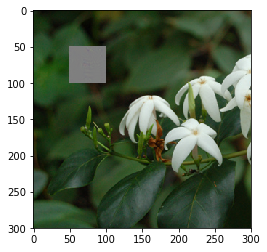

(1, 300, 300, 3)


In [104]:
plot_adversarial_image(a.reshape(300, 300, 3))
print(a.shape)
#print("adv.shape =", adv.shape)
#print("adv1.shape =", adv1.shape)
# Convert array to Image
#adv_img =  PIL.Image.fromarray(adv1, mode="RGB")

#show_image(preprocessing(my_raw_pillow_image)[2])

In [122]:
print("adv =", adv)

adv2 = 

SyntaxError: invalid syntax (<ipython-input-122-0e31cc004605>, line 3)

In [136]:
print(imagenet_labels[np.where(my_probs == np.amax(my_probs))[0][0]] )

daisy


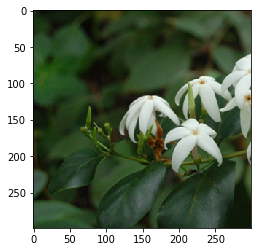

In [138]:
my_pillow_image = preprocessing(my_raw_pillow_image)[0]
show_image(my_pillow_image)